# Introduction à pytorch

Nous verrons les aspects suivants: 

   - charger des données
   - définir un modèle
   - entrainer un modèle
   - évaluer un modèle

In [100]:
import torch
from torch import nn, tensor
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

## Première version simple

Pytorch peut récupérer certains jeux de données connus directement. Nous verrons plus moins comment faire pour des données spécifiques

In [106]:
#from torchvision import datasets
training_data = datasets.MNIST(
    root="~/Ressources/MNIST",
    train=True,
    download=True,
    transform=ToTensor(),
    #target_transform = ToTensor()
)

test_data = datasets.MNIST(
    root="~/Ressources/MNIST",
    train=False,
    download=True,
    transform=ToTensor()
)

training_data.data.shape

torch.Size([60000, 28, 28])

torch.Size([1, 28, 28]) 5


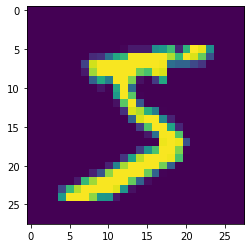

In [3]:
img1, label1 = training_data[0] 
print(img1.shape,label1)
plt.imshow(img1.squeeze())

In [4]:
import numpy as np
torch.tensor(np.array([label1]))

tensor([5])

### Définition du modèle

In [5]:
class MyModel(nn.Module):
    """modèle basique linéaire"""
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)
            
    
    def forward(self,input):
        scores = self.linear(self.flatten(input))
        return scores

In [6]:
model = MyModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### Entrainement

version simple: exemples donnés 1 par 1,  une seule époque. 

In [7]:
for input, target in tqdm(training_data):    
    optimizer.zero_grad() # on remet les gradients à 0
    output = model(input) # on fait une passe "forward"
    target = torch.tensor([target])
    loss = loss_fn(output, target)  # on calcule la loss par rapport à la bonne réponse
    loss.backward() # on calcule les gradients par backpropagation
    optimizer.step() # mise à jour des paramètres du modèle

100%|██████████| 60000/60000 [00:20<00:00, 2994.35it/s]


### Evaluation


In [8]:
correct = 0 
total = len(test_data)
errors = []

for input, target in tqdm(test_data): 
    output = model(input)
    eval = (output.argmax(1) == target).item() # True or False
    if not(eval): 
        errors.append((input,target,output.argmax(1).item()))
    correct += eval
print(correct/total)

100%|██████████| 10000/10000 [00:01<00:00, 8861.16it/s]

0.9023


In [12]:
output.argmax(1).item()

6

### Analyse d'erreurs

prédit: 6 au lieu de 5


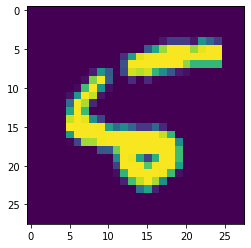

prédit: 0 au lieu de 4


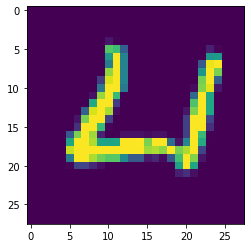

prédit: 3 au lieu de 2


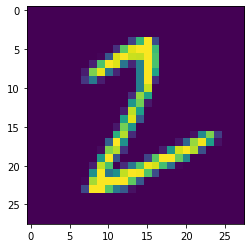

prédit: 3 au lieu de 1


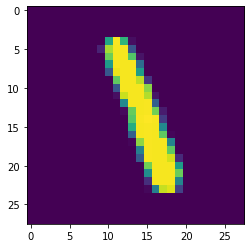

prédit: 2 au lieu de 3


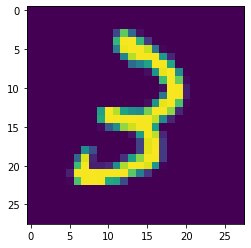

prédit: 7 au lieu de 2


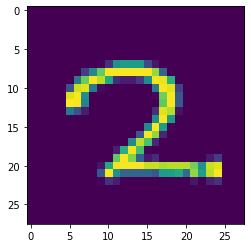

prédit: 9 au lieu de 7


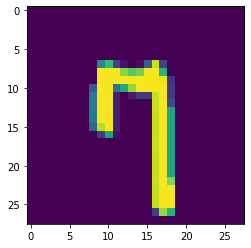

prédit: 4 au lieu de 9


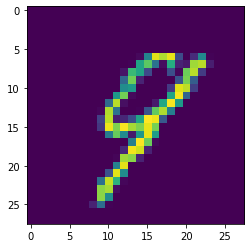

prédit: 1 au lieu de 7


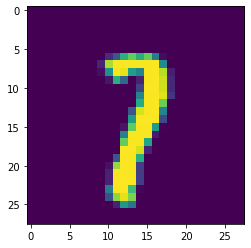

prédit: 4 au lieu de 7


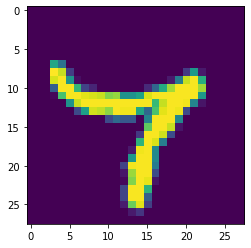

In [9]:
for inst in errors[:10]:
    print(f"prédit: {inst[2]} au lieu de {inst[1]}")
    plt.imshow(inst[0].squeeze())
    plt.show()
    

## Deuxième version avec des batchs d'exemples

En général on fait la mise à jour en considérant un paquet d'exemple à la fois (batch), torch fournit aussi une API pour lire des jeux de données par batch 

Reprenons MNIST: 

In [13]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [14]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.size())
print(train_labels.size())

torch.Size([64, 1, 28, 28])
torch.Size([64])


on voit qu'on a maintenant ajouté une dimension: chaque valeur issue par le loader regroupe 64 instances d'images dans un seul tenseur (idem pour les labels). 
Il n'y a presque rien à changer dans la boucle d'entrainement ! Juste plus besoin de convertir le label en tenseur à une valeur. 

In [15]:
model = MyModel()
for input, target in tqdm(train_dataloader):    
    optimizer.zero_grad() 
    output = model(input)
    loss = loss_fn(output, target) 
    loss.backward() 
    optimizer.step() 

100%|██████████| 938/938 [00:04<00:00, 225.09it/s]


On voit que l'itération se fait bien par batch (et va donc plus vite: moins de mise à jour). 
On peut reprendre la boucle de test, il est juste plus compliqué d'isoler les erreurs pendant le test, et on doit sommer les résultats par batch

In [16]:
correct = 0 
total = len(test_data)

for input, target in tqdm(test_dataloader): 
    output = model(input)
    eval = (output.argmax(1) == target).type(torch.float).sum().item() # True or False
    correct += eval
print(correct/total)

100%|██████████| 157/157 [00:00<00:00, 229.78it/s]

0.0763


Forcément avec moins de mises à jour, les résultats sont pires. Continuons un peu

In [57]:
# test tensorboard
# need to run in terminal: tensorboard --logdir=runs
# and open interface http://localhost:6006/

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

model = MyModel()
for epoch in range(10):
    print(f"epoch={epoch}")
    for input, target in tqdm(train_dataloader):    
        optimizer.zero_grad() 
        output = model(input)
        loss = loss_fn(output, target) 
        writer.add_scalar('Loss/train', loss, epoch)
        loss.backward() 
        optimizer.step() 

epoch=0


100%|██████████| 938/938 [00:04<00:00, 217.26it/s]


epoch=1


100%|██████████| 938/938 [00:04<00:00, 209.84it/s]


epoch=2


100%|██████████| 938/938 [00:04<00:00, 208.11it/s]


epoch=3


100%|██████████| 938/938 [00:04<00:00, 211.41it/s]


epoch=4


100%|██████████| 938/938 [00:04<00:00, 217.72it/s]


epoch=5


100%|██████████| 938/938 [00:04<00:00, 213.39it/s]


epoch=6


100%|██████████| 938/938 [00:04<00:00, 216.46it/s]


epoch=7


100%|██████████| 938/938 [00:04<00:00, 215.04it/s]


epoch=8


100%|██████████| 938/938 [00:04<00:00, 218.73it/s]


epoch=9


100%|██████████| 938/938 [00:04<00:00, 222.54it/s]


In [97]:
correct = 0 
total = len(test_data)
preds = []
all_sc = []

for input, target in tqdm(test_dataloader): 
    output = model(input)
    eval = (output.argmax(1) == target).type(torch.float).sum().item() # True or False
    correct += eval
    scores, best = output.max(1)
    # pour enlever du graphe de calcul sinon le gradient continue à être calculé
    scores = scores.new_tensor(scores)
    all_sc.append(scores)
    preds.append(best)
    

  0%|          | 0/157 [00:00<?, ?it/s]<ipython-input-97-bc10a5308fef>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  scores = scores.new_tensor(scores)
100%|██████████| 157/157 [00:00<00:00, 236.59it/s]


In [98]:
preds = torch.cat(preds)
all_sc = torch.cat(all_sc)
print(correct/total)

0.0898


In [95]:
all_sc

tensor([0.3247, 0.2579, 0.2113,  ..., 0.1875, 0.5146, 0.3477])

In [96]:
preds

tensor([4, 4, 7,  ..., 1, 5, 5])